Watershed Challenge
Daniel Geraldini Zem

# Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score 

# 1. Importing Dataset

In [3]:
flux_df = pd.read_csv(r"C:\Users\danie\OneDrive\Área de Trabalho\Bain Company\flux.csv")

# 2. EDA

In [5]:
# First of all, take a look how the data is organized
flux_df.info()
flux_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180480 entries, 0 to 4180479
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date        object 
 1   basin_id    int64  
 2   flux        float64
 3   precip      float64
 4   temp_max    float64
 5   gauge_name  object 
 6   lat         float64
 7   lon         float64
 8   mean_elev   float64
 9   area_km2    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 318.9+ MB


,basin_id,flux,precip,temp_max,lat,lon,mean_elev,area_km2
count,4.180480e+06,4.180480e+06,4.175037e+06,4.175037e+06,4.180480e+06,4.180480e+06,4.180480e+06,4.180480e+06
mean,7.179757e+06,5.253340e+01,2.947445e+00,1.365728e+01,-3.569572e+01,-7.129595e+01,1.760129e+03,2.404876e+03
std,3.180965e+06,1.676027e+02,8.766749e+00,6.615037e+00,8.047659e+00,1.254339e+00,1.382121e+03,4.322051e+03
min,1.001001e+06,0.000000e+00,0.000000e+00,-1.160359e+01,-5.494690e+01,-7.366670e+01,1.181229e+02,1.789123e+01
25%,4.558001e+06,8.680000e-01,0.000000e+00,9.162867e+00,-3.915000e+01,-7.231670e+01,5.847012e+02,3.761001e+02
50%,7.350003e+06,5.171000e+00,0.000000e+00,1.321396e+01,-3.588420e+01,-7.137190e+01,1.195311e+03,8.205541e+02
75%,9.416001e+06,2.990000e+01,6.422626e-01,1.805745e+01,-3.126560e+01,-7.050670e+01,3.048161e+03,2.461610e+03
max,1.293000e+07,1.580500e+04,2.132120e+02,4.081117e+01,-1.784280e+01,-6.763920e+01,4.910152e+03,5.224367e+04


In [10]:
# Looking at the data types, "date" should be converted to datetime format and "basin_id" will be converted into string since
# there are no quantitative value for it. Other data's types are fine.
flux_df["date"] = flux_df["date"].astype("datetime64")
flux_df["basin_id"] = flux_df["basin_id"].astype(str)

In [11]:
# Now checking for missing values
flux_df.isna().sum() # Here we will see that there are 5443 missing values in "precip" and "temp_max"

date             0
basin_id         0
flux             0
precip        5443
temp_max      5443
gauge_name       0
lat              0
lon              0
mean_elev        0
area_km2         0
dtype: int64

In [13]:
# Lets check how this missing data is spread along the years of our dataset
nan_by_year = flux_df[["date","precip","temp_max"]].copy()
nan_by_year = nan_by_year[(nan_by_year["precip"].isna()) | (nan_by_year["temp_max"].isna())]
nan_by_year = nan_by_year["date"].apply(lambda x: x.year).value_counts()
nan_by_year
# Since all the data is from 2020.

2020    5443
Name: date, dtype: int64

,data_percentage
2012,3.066705
2013,3.032188
2010,2.956120
2007,2.948609
2005,2.931888
2011,2.924975
2004,2.894476
2016,2.871058
2014,2.862901
2006,2.858428


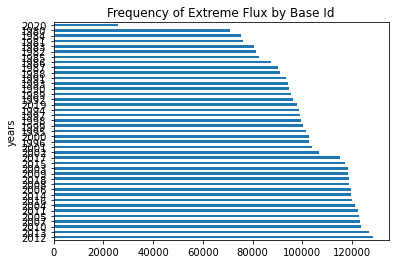

In [15]:
# Now we'll check how much data from 2020 we have.
occurence_by_year = flux_df["date"].apply(lambda x: x.year).value_counts().plot(kind='barh', xlabel='years', ylabel='Frequency', title="Frequency of Extreme Flux by Base Id")
occurence_by_year_df = (100*flux_df["date"].apply(lambda x: x.year).value_counts()/flux_df["date"].count()).to_frame(name="data_percentage")
occurence_by_year_df
# Since 2020 represents only 0.61% of our data and has fewer records than the other years, we will delete it.

In [16]:
# Here we make sure that there are no more missing values.
flux_df = flux_df[flux_df["date"] < np.datetime64('2020-01-01')]
flux_df.isna().sum() 

date          0
basin_id      0
flux          0
precip        0
temp_max      0
gauge_name    0
lat           0
lon           0
mean_elev     0
area_km2      0
dtype: int64

<AxesSubplot:title={'center':'Frequency of Extreme Flux by Base Id'}, ylabel='years'>

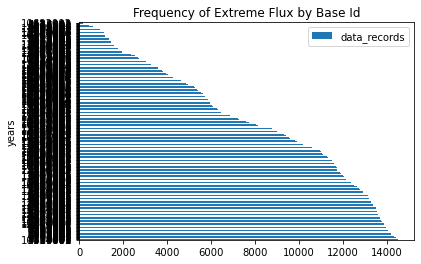

In [19]:
# Now the numbers of record by Base ID (basin_id) will be analyzed.
occurence_by_base_id_df = flux_df["basin_id"].value_counts().to_frame(name="data_records")
occurence_by_base_id_df.plot(kind='barh', xlabel='years', ylabel='Frequency', title="Frequency of Extreme Flux by Base Id")
# Looking only at the bars without worrying with the base id labels on y-axis, we can see that there are some Bases that have
# fewer values than others, since the ones with the most data have around 14k records, we will exclude from the dataset the bases
# that have less than 7000 records so we can be "safe" to deal with a wide range of dates.

In [21]:
# Excluding bases that have less than 7000 records.
remove_base_id = list(occurence_by_base_id_df[occurence_by_base_id_df["data_records"] < 7000].index)
flux_df = flux_df[~flux_df["basin_id"].isin(remove_base_id)]
flux_df

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
6125,1980-01-01,1001002,1.620,0.000000,11.287282,Rio Caquena En Vertedero,-17.9942,-69.2550,4652.603986,467.556222
6126,1980-01-02,1001002,1.240,0.000000,12.078774,Rio Caquena En Vertedero,-17.9942,-69.2550,4652.603986,467.556222
6127,1980-01-03,1001002,1.010,0.000000,12.563833,Rio Caquena En Vertedero,-17.9942,-69.2550,4652.603986,467.556222
6128,1980-01-04,1001002,0.830,0.000000,13.077723,Rio Caquena En Vertedero,-17.9942,-69.2550,4652.603986,467.556222
6129,1980-01-05,1001002,0.753,0.000000,13.316867,Rio Caquena En Vertedero,-17.9942,-69.2550,4652.603986,467.556222
...,...,...,...,...,...,...,...,...,...,...
4167816,2019-12-27,12876001,13.513,2.370108,14.717016,Rio Grande En Tierra Del Fuego,-53.8928,-68.8844,259.117332,2841.024341
4167817,2019-12-28,12876001,13.549,1.265753,14.231168,Rio Grande En Tierra Del Fuego,-53.8928,-68.8844,259.117332,2841.024341
4167818,2019-12-29,12876001,12.982,0.000000,13.559340,Rio Grande En Tierra Del Fuego,-53.8928,-68.8844,259.117332,2841.024341
4167819,2019-12-30,12876001,12.633,1.158569,12.725022,Rio Grande En Tierra Del Fuego,-53.8928,-68.8844,259.117332,2841.024341


In [22]:
# Now lets see the events satistical information 
flux_df[["flux","precip","temp_max"]].describe()
# Flux and precipitation are ok but for temp max there are some negative temperatures, lets take a look into it.

,flux,precip,temp_max
count,3.352698e+06,3.352698e+06,3.352698e+06
mean,4.369031e+01,2.826518e+00,1.361471e+01
std,1.509129e+02,8.685313e+00,6.639582e+00
min,0.000000e+00,0.000000e+00,-1.160359e+01
25%,8.740000e-01,0.000000e+00,9.143759e+00
50%,5.090000e+00,0.000000e+00,1.317996e+01
75%,2.760000e+01,3.852723e-01,1.801864e+01
max,1.580500e+04,2.132120e+02,4.081117e+01


<AxesSubplot:title={'center':'LatxLon tuples for temp max < 0ºC'}, xlabel='lat', ylabel='lon'>

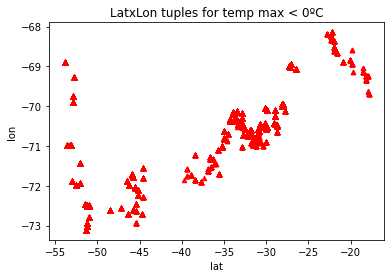

In [24]:
# Cross checking latitude and Longitude info to have an idea where they are located.
place_minus_temp = flux_df[flux_df["temp_max"] < 0][["lat","lon","temp_max"]].copy()
place_minus_temp["coordinates"] = place_minus_temp["lat"].astype(str) + "," + place_minus_temp["lon"].astype(str)
place_minus_temp.plot.scatter(x = 'lat',y='lon',c="red",marker="^",title="LatxLon tuples for temp max < 0ºC")

# Looking at the sctter plot generated, those places seens to be in the very west of Chile, near the mountains and the ocean,
# So it makes sense to have lower temperatures on those place, hence, everything is ok.

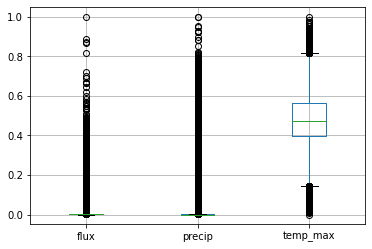

In [27]:
# Now we will look into the data distribution along the flux, precip and temp_max columns
# We will scale the numbers to put all of them on the same plot using the Min Max Scaler from sklearn.
eventes_sccaled_df = flux_df[["flux","precip","temp_max"]].copy()
eventes_sccaled_df[["flux","precip","temp_max"]] = preprocessing.MinMaxScaler().fit_transform(eventes_sccaled_df[["flux","precip","temp_max"]])
boxplot_events_scaled = eventes_sccaled_df.boxplot(column=["flux","precip","temp_max"], return_type='axes')

# Despite the boxplot showing we would have a lot of "outliers" they seen to be making sense if we analyze the satistical
# information of the dataset (flux_df[["flux","precip","temp_max"]].describe()). So far so good.

# To run for each, just run the following commands:
# >>>boxplot_flux = flux_df.boxplot(column=['flux'], return_type='axes')
# >>>boxplot_temp_max = flux_df.boxplot(column=['precip'], return_type='axes')
# >>>boxplot_precipitation = flux_df.boxplot(column=['temp_max'], return_type='axes')

In [28]:
# Finally, we will check if every year has at list one record.
years_data_list = list(occurence_by_year_df.index)
years_not_in_the_dataset = []
for y in list(range(min(years_data_list),max(years_data_list),1)):
    if y not in years_data_list:
        years_not_in_the_dataset.append(y)
years_not_in_the_dataset
# Since the list is empty, there are data for every year.

[]

# 3. Plot Flux, Temperature and Precipitation

Plot one time series

In [36]:
def plot_one_timeserie(cod_station, variable, min_date, max_date):
    '''
    This function will plot the time series for a given variable, base id, start
    and end date within the dataset. First this function will create a temporary
    dataframe to apply all the filters without changing the original one. After
    data it will plot the time series.

    Parameters
    ----------
    cod_station : String
        Base Id (Any values from column basin_id in the dataset).
    variable : String
        Variable to be seen in the plot (flux, precip or temp_max).
    min_date : String
        Start date for the time series (Must be in YYYY-MM-DD format).
    max_date : String
        End date for the time series (Must be in YYYY-MM-DD format).

    '''
    #Filter the date
    temp_df = flux_df[(flux_df["basin_id"]==cod_station) & (flux_df["date"]>=min_date) & (flux_df["date"]<=max_date)][["date","{}".format(variable)]].copy()
    
    #Set date as an index for the time series
    temp_df = temp_df.set_index("date")
    
    #Plot the data
    plt.plot(temp_df["{}".format(variable)])
    plt.xlabel("Date")
    plt.ylabel("{}".format(variable))
    plt.title("{} time series for base {}".format(variable, cod_station))
    plt.show()


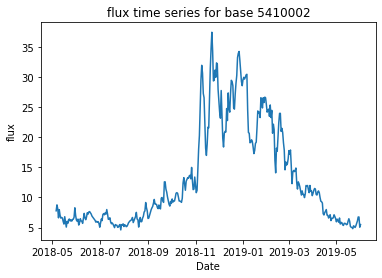

In [37]:
# Run one example
plot_one_timeserie("5410002","flux",'2018-05-06','2019-06-01')

Plot three time series at the same time

In [38]:
def plot_three_timeseries(cod_station, min_date, max_date):
    '''
    This function will plot the Flux, Preciptation and Max Temperature time series
    for a given base id, start and end date within the dataset. 
    First this function will create a temporary dataframe to apply all the
    filters without changing the original one. After data it will plot the time series.

    Parameters
    ----------
    cod_station : String
        Base Id (Any values from column basin_id in the dataset).
    min_date : String
        Start date for the time series (Must be in YYYY-MM-DD format).
    max_date : String
        End date for the time series (Must be in YYYY-MM-DD format).

    '''
    #Filter the date
    temp_df = flux_df[(flux_df["basin_id"]==cod_station) & (flux_df["date"]>=min_date) & (flux_df["date"]<=max_date)][["date","flux","precip","temp_max"]].copy()
    
    #Set date as an index for the time series
    temp_df = temp_df.set_index("date")
    
    #Scaling all the variables with MinMaxScaler from sklearn
    temp_df[["flux","precip","temp_max"]] = preprocessing.MinMaxScaler().fit_transform(temp_df[["flux","precip","temp_max"]])
    
    #Plot the data
    plt.plot(temp_df["flux"],label="Flux",color="orange")
    plt.plot(temp_df["precip"],label="Preciptation",color="green")
    plt.plot(temp_df["temp_max"],label="Max temperature",color="red")
    plt.xlabel("Date")
    plt.ylabel("Variables")
    plt.title("Flux, Preciptation and Max temperature time series for base {}".format(cod_station))
    plt.legend(loc=0) #Best Position
    plt.show()


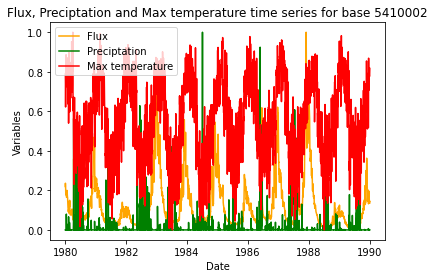

In [39]:
# Run one example
plot_three_timeseries("5410002",'1980-01-01','1990-01-01')

# 4. Create Variables (flux_extreme, temp_extreme, precip_extreme)

In [35]:
# First we will create a function to find the season for a given date.
def find_season_south_hemisphere(x):
    '''
    This function will define the season of a give date.

    Parameters
    ----------
    x : Pd.Series
        Series of a pd.Dataframe.

    Returns
    -------
    season : String
        Season for the given date.

    '''
    #Since x will be the date record of a pd.Series, we will extract the day and month
    month = x.month
    day = x.day
    
    if month in [1,2,3]:
        season = "Summer"
    elif month in [4,5,6]:
        season = "Autumn"
    elif month in [7,8,9]:
        season = "Winter"
    else:
        season = "Spring"
    
    if month == 3 and day >= 20:
        season = "Autumn"
    elif month == 6 and day >= 21:
        season = "Winter"
    elif month == 9 and day >= 22:
        season = "Spring"
    elif month == 12 and day >= 21:
        season = "Summer"
    
    return season

In [40]:
# Insert "season" column into the dataframe.
flux_df["season"] = flux_df["date"].map(find_season_south_hemisphere)

In [41]:
# Calculate the 95 percentile for all seasons
flux_95_percentile = {
    "Summer": np.percentile(flux_df[(flux_df["season"]=="Summer")]["flux"],95),
    "Autumn": np.percentile(flux_df[(flux_df["season"]=="Autumn")]["flux"],95),
    "Winter": np.percentile(flux_df[(flux_df["season"]=="Winter")]["flux"],95),
    "Spring": np.percentile(flux_df[(flux_df["season"]=="Spring")]["flux"],95)
}

#Find the preciptation's 95 Percentiles for all seasons
precip_95_percentile = {
    "Summer": np.percentile(flux_df[(flux_df["season"]=="Summer")]["precip"],95),
    "Autumn": np.percentile(flux_df[(flux_df["season"]=="Autumn")]["precip"],95),
    "Winter": np.percentile(flux_df[(flux_df["season"]=="Winter")]["precip"],95),
    "Spring": np.percentile(flux_df[(flux_df["season"]=="Spring")]["precip"],95)
}

#Find the max temperature's 95 Percentiles for all seasons
temp_max_95_percentile = {
    "Summer": np.percentile(flux_df[(flux_df["season"]=="Summer")]["temp_max"],95),
    "Autumn": np.percentile(flux_df[(flux_df["season"]=="Autumn")]["temp_max"],95),
    "Winter": np.percentile(flux_df[(flux_df["season"]=="Winter")]["temp_max"],95),
    "Spring": np.percentile(flux_df[(flux_df["season"]=="Spring")]["temp_max"],95)
}

In [42]:
# Create the columns for those variables and assigned the values based on the conditions provided in the instructions.
flux_df[["flux_extreme","precip_extreme","temp_extreme"]] = 0

for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    flux_df.loc[(flux_df["season"]==season) & (flux_df["flux"]>flux_95_percentile[season]),"flux_extreme"] = 1
    flux_df.loc[(flux_df["season"]==season) & (flux_df["precip"]>precip_95_percentile[season]),"precip_extreme"] = 1
    flux_df.loc[(flux_df["season"]==season) & (flux_df["temp_max"]>temp_max_95_percentile[season]),"temp_extreme"] = 1

In my opinion, this is not the best way to do it because along the years, the temperatures for all the seasons were changing so
we are not being fair to the oldest values when calculating the 95 percentile for the oldest value. My approach would be to follow the same methodology but instead of using all the records, use only to the respectively year that is being analyzed.

# 5. Plot Variable flux_extreme

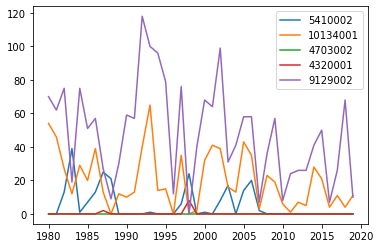

In [43]:
# For data visualization purpose, we will select only the top 5 base Ids based on data record count, if it is desirable to see
# all of them, just delete "[:5]" on the next line.
top_5_bases = list(flux_df['basin_id'].value_counts().index)[:5]
flux_extreme_df_plot = flux_df[flux_df['basin_id'].isin(top_5_bases)].copy()
flux_extreme_df_plot["year"] = flux_extreme_df_plot["date"].apply(lambda x: x.year)
flux_extreme_df_plot = flux_extreme_df_plot.sort_values(by=['basin_id', 'year'],ascending=[True,True])
flux_extreme_df_plot = flux_extreme_df_plot[["basin_id","flux_extreme","year"]].groupby(["basin_id","year"],as_index=False).sum()

for base in top_5_bases:
    x = flux_extreme_df_plot[flux_extreme_df_plot["basin_id"]==base]["year"]
    y = flux_extreme_df_plot[flux_extreme_df_plot["basin_id"]==base]["flux_extreme"]
    plt.plot(x, y, label = base)
    
plt.legend()
plt.show()

If we take a look into the plot above, it is possible to see that there are different patterns for each base Ids, for example, there are some that have spikes form extreme flux's events along the years, but some remains flat for almost all the years.

# 6. Plot extreme events during time

In [44]:
# First we will create the function to plot those extreme events
def plot_extreme_events_timeseries(df,extreme_event):
    '''
    This function will plot a Extreme Event time series.
    First this function will create a temporary dataframe to apply all the
    filters without changing the original one. After data it will plot the time series.

    Parameters
    ----------
    df : pandas.DataFrame
        Initial Dataset.
    extreme_event : String
        flux_extreme, precip_extreme or temp_extreme.

    '''
    #Filter the data
    temp_df = df[["date",extreme_event]].copy()
    temp_df["ocurrence"] = 1
    temp_df = temp_df.groupby(by=["date"]).sum()
    temp_df["{}_percentage".format(extreme_event)] = 100*(temp_df["{}".format(extreme_event)]/temp_df["ocurrence"]).round(4)

    #Plot the data
    plt.plot(temp_df["{}_percentage".format(extreme_event)],label=extreme_event,color="blue",linewidth=0.5)
    plt.xlabel("Date")
    plt.ylabel("Percentage")
    plt.title("Percentage of {} Events time series".format(extreme_event))
    plt.legend(loc=0) #Best Position
    plt.show()

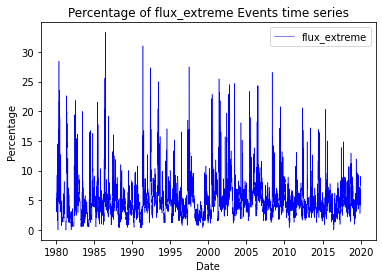

In [45]:
# Plot for Extreme Flux events
plot_extreme_events_timeseries(flux_df,"flux_extreme")
# Despite the spikes, they have became more often.

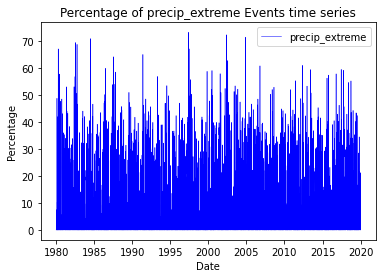

In [46]:
# Plot for Extreme Precipitation events
plot_extreme_events_timeseries(flux_df,"precip_extreme")
# Despite the spikes, their seasonality remains the same

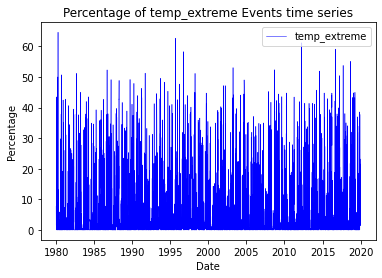

In [47]:
# Plot for Extreme Temperature events
plot_extreme_events_timeseries(flux_df,"temp_extreme")
# Despite the spikes, their seasonality remains the same

# 7. Extreme Flux Prediction

In [60]:
# Model proposal: Logistic Regression model for a given base id.
# Varaibles created: flux_extreme_yesterday - 1 if a flux extreme event was registred on the day before, 0 otherwise.
# Variable Chosen: Based on the correlation Matrix: "flux", "precip" and "flux_extreme_yesterday". 
# 'basin_id','gauge_name','lat','lon' were not considered in the model because they would be redundant to basin_id
# How to used: Once in production, once you input the information for the present day, it will output the probability of an
# extreme flux event for the next day.
def predictive_model_logistic_regression(base_id):
    '''
    This function will create and run a logistic regression model for a given
    base id and will print two correlation matrices, the first one is related
    to all the variables and the second one to the columns that have remained.
    In addition, it will print the accuracy and confusion matrix for this model.

    Parameters
    ----------
    base_id : String
        Base Id.

    Returns
    -------
    Nothing.

    '''
    # Calculate the percentile just as before
    model_df = flux_df[flux_df["basin_id"]==base_id]
    model_df = model_df.reset_index(drop=True)
    model_df_flux_95_percentile = {
        "Summer": np.percentile(model_df[(model_df["season"]=="Summer")]["flux"],95),
        "Autumn": np.percentile(model_df[(model_df["season"]=="Autumn")]["flux"],95),
        "Winter": np.percentile(model_df[(model_df["season"]=="Winter")]["flux"],95),
        "Spring": np.percentile(model_df[(model_df["season"]=="Spring")]["flux"],95)
    }
    
    # Check if flux is extreme and insert into the data 
    for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
        model_df.loc[(model_df["season"]==season) & (model_df["flux"]>model_df_flux_95_percentile[season]),"flux_extreme"] = 1
    
    # Drop columns that are not necessary
    model_df.drop(columns=['basin_id','gauge_name','lat','lon'],inplace=True)
    
    # Convert seasons strings into factor to be usefull to the model
    model_df["season"].replace({'Winter':1, 'Spring':2, 'Summer':3, 'Autumn':4},inplace=True)
    
    # Insert month info
    model_df["month"]=model_df["date"].apply(lambda x: x.month)
    
    # Insert information if the flux was extreme on the next day
    model_df["flux_extreme_next_day"] = model_df["flux_extreme"].shift(-1)
    model_df = model_df.dropna()
    
    # Generate first correlation matrix to check which columns to drop
    correlation_matrix = model_df.corr(method ='pearson') #Mean elevation and area does not have any corr, delete
    correlation_matrix
    model_df.drop(columns=['area_km2','mean_elev'],inplace=True)
    
    # Generate secon correlation matrix to see if they remain.
    correlation_matrix = model_df.corr(method ='pearson')
    correlation_matrix # Only the correlation for flux, precipitation and flux_extrem_yesterday are revlevant for the problem.
    
    # Data prep for training and test datasets
    independent_variables_df = model_df[["flux","precip","flux_extreme"]]
    dependent_variables_df = model_df["flux_extreme_next_day"]
    X_train,X_test,y_train,y_test=train_test_split(independent_variables_df,dependent_variables_df,test_size=0.3)
    
    # Run logistics Regression
    logistic_regression =  LogisticRegression() 
    logistic_regression.fit(X_train,y_train)
    y_pred = logistic_regression.predict(X_test)

    # Calculate model results
    accuracy = accuracy_score(y_test,y_pred)*100
    confusion_mat = confusion_matrix(y_test,y_pred)
    
    # Print the results
    print("Accuracy is",accuracy)
    print("Confusion Matrix")
    sns.heatmap(confusion_mat, annot=True,fmt='g',cmap="Blues")

Accuracy is 98.4159779614325
Confusion Matrix


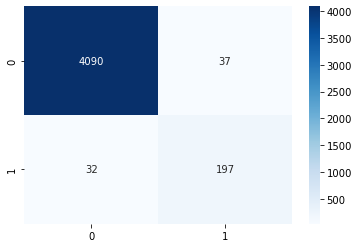

In [61]:
predictive_model_logistic_regression("5410002")

In [64]:
def predictive_model_logistic_regression_next_day(base_id,flux_present_day,precipitation_present_day,flux_extreme_present_day):
    '''
    This function will create and run a logistic regression model for a given
    base id and data from present day (flux,precipitation and temperature) to predict
    the probability of an extreme flux event on the next day.

    Parameters
    ----------
    base_id : String
        Base Id.
    flux_present_day : Int
        Flux data for the present day.
    precipitation_present_day : Int
        Precipitation data for the present day.
    flux_extreme_present_day : Int
        Extreme Flux evento for present day.

    Returns
    -------
    Nothing.

    '''
    # Calculate the percentile just as before
    model_df = flux_df[flux_df["basin_id"]==base_id]
    model_df = model_df.reset_index(drop=True)
    model_df_flux_95_percentile = {
        "Summer": np.percentile(model_df[(model_df["season"]=="Summer")]["flux"],95),
        "Autumn": np.percentile(model_df[(model_df["season"]=="Autumn")]["flux"],95),
        "Winter": np.percentile(model_df[(model_df["season"]=="Winter")]["flux"],95),
        "Spring": np.percentile(model_df[(model_df["season"]=="Spring")]["flux"],95)
    }
    
    # Check if flux is extreme and insert into the data 
    for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
        model_df.loc[(model_df["season"]==season) & (model_df["flux"]>model_df_flux_95_percentile[season]),"flux_extreme"] = 1
    
    # Drop columns that are not necessary
    model_df.drop(columns=['basin_id','gauge_name','lat','lon'],inplace=True)
    
    # Convert seasons strings into factor to be usefull to the model
    model_df["season"].replace({'Winter':1, 'Spring':2, 'Summer':3, 'Autumn':4},inplace=True)
    
    # Insert month info
    model_df["month"]=model_df["date"].apply(lambda x: x.month)
    
    # Insert information if the flux was extreme on the next day
    model_df["flux_extreme_next_day"] = model_df["flux_extreme"].shift(-1)
    model_df = model_df.dropna()
    
    # Generate first correlation matrix to check which columns to drop
    correlation_matrix = model_df.corr(method ='pearson') #Mean elevation and area does not have any corr, delete
    correlation_matrix
    model_df.drop(columns=['area_km2','mean_elev'],inplace=True)
    
    # Generate secon correlation matrix to see if they remain.
    correlation_matrix = model_df.corr(method ='pearson')
    correlation_matrix # Only the correlation for flux, precipitation and flux_extrem_yesterday are revlevant for the problem.
    
    # Data prep for training and test datasets
    independent_variables_df = model_df[["flux","precip","flux_extreme"]]
    dependent_variables_df = model_df["flux_extreme_next_day"]
    X_train,X_test,y_train,y_test=train_test_split(independent_variables_df,dependent_variables_df,test_size=0.3)
    
    # Run logistics Regression
    logistic_regression =  LogisticRegression() 
    logistic_regression.fit(X_train,y_train)
    
    # Probability for next day
    predict_tomorrow_info_df =  pd.DataFrame(np.array([[flux_present_day,precipitation_present_day,flux_extreme_present_day]]),
                   columns=['flux', 'precip', 'flux_extreme'])
    y_pred_probability = logistic_regression.predict_proba(predict_tomorrow_info_df)
    probability = y_pred_probability[0][-1] 
    
    # Print the results
    print("Probability of extreme flux event for next day is ",round(probability*100,2),"%")

In [63]:
predictive_model_logistic_regression_next_day("5410002",53,0,1)

Probability of extreme flux event for next day is  68.15 %


# 8. Analyze Model Results

a.) 
Performance of the model: 98.7%
Metrics consider to be best suited for this problem: During the
Most Important Variables: Flux ("flux"),Precipitation ("precip") and Extreme Flux Event ("flux_extreme")
About the results: At first I've though that the model could be over-fitting, but after performing additional tests, the model
remain with a high performance. When looking at the confusion matrix one good thing to point it out is that we have low cases of false negative (FN) what is a good thing, because it is desirabled to reduce this number as much as possible. 

b.)
Metrics used in the model: Hold-out of 70%/30% (70% for training and 30% for testing), penalty: L2, solver: lbfgs
Is it a useful model: In my opinion this is a useful model due to the fact that on the present day, it is possible to predict the probability of the next day, with further tunning in the model, this range could be extend to weeks, giving more time for a decision making process.